# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head(15))
#print(data.info())

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20  13000000.0      108.00  2019-03-07T00:00:00      3   
1              7   3350000.0       40.40  2018-12-04T00:00:00      1   
2             10   5196000.0       56.00  2015-08-20T00:00:00      2   
3              0  64900000.0      159.00  2015-07-24T00:00:00      3   
4              2  10000000.0      100.00  2018-06-19T00:00:00      2   
5             10   2890000.0       30.40  2018-09-10T00:00:00      1   
6              6   3700000.0       37.30  2017-11-02T00:00:00      1   
7              5   7915000.0       71.60  2019-04-18T00:00:00      2   
8             20   2900000.0       33.16  2018-05-23T00:00:00      1   
9             18   5400000.0       61.00  2017-02-26T00:00:00      3   
10             5   5050000.0       39.60  2017-11-16T00:00:00      1   
11             9   3300000.0       44.00  2018-08-27T00:00:00      2   
12            10   3890000.0       54.00  2016-06-30T00:00:00   

### Вывод

1. Изучение данных:
В представленной таблице всего 23699 строк(наблюдений) и 22 столбца. В следующих столбцах есть пропуски:'ceiling_height' - заполнены всего 14504 строки, 'floors_total' - 23613, 'living_area' - 21796, 'is_apartment' - 2775 (самый незаполненный столбец), 'kitchen_area' - 21421, 'balcony' - 12180, 'locality_name' - 23650, 'airports_nearest' - 18157, 'cityCenters_nearest' - 18180, 'parks_around3000' - 18181, 'parks_nearest' - 8079, 'ponds_around3000' - 18181, 'ponds_nearest' - 9110, 'days_exposition' - 20518. В наименованиях столбцов пробелов не наблюдается, слова указаны через нижнее подчеркивание. Наименование нескольких столбцов можно скорректировать, например вместо cityCenters_nearest указать city_сenters_nearest. 

2. пропущенные значения:
Столбец "ceiling_height"  имеет много пропущенных значений, пропуски попробуем заменить на среднеарифметическое или медианной значение. Столбец "living_area", пропуски могут быть связаны, если это не квартира, а аппартаменты, в этом случае такие пропуски можно заменить на 0(данную догадку подтверждает высокая стоимость и большая площадь недвижимости, но в случае если у объекта есть площадь кухни, то это уже не аппартаменты). Столбец "is_apartment" - большое количество пропусков скорее связано с тем, что это жилые квартиры, и такие пропуски можно заменить на соответствующее булевое значение. Столбец "kitchen_area" - пропуски могут быть в аппартаментах, поэтому такие пропуски можно заменить на 0. Столбец "balcony" - согласно инструкции к проекту, меняем на 0. Столбец "airports_nearest" - предположить логическую замену пропускам затруднительно, поэтому оставим эти пропуски. Аналогичная ситуация со столбцом "cityCenters_nearest". Пропуски в столбце "parks_around3000", могут быть связаны с отсутсвием парка, можно заменить на 0. Пропуски в столбце "parks_nearest" как следствие, могут быть связаны с отсутвием парков поблизости и соответственно в данном случае есть пропущенное значение. Со столбцами "ponds_around3000" и "ponds_nearest" ситуация аналогичная паркам. Пропуски в столбце "days_exposition" возможно связаны с тем, что недвижимость еще не продана, такие пропуски нужно заменить максимальным зачением в рассматриваемом временном промежутке.

3. По типам столбцов:
столбец 'first_day_exposition' имет тип object, необходимо будет изменить на datetime64, "floors_total" имеет тип float64, так как не может быть полэтажа, приведем к типу int64, "is_apartment" имеет тип object, изменим на bool, "balcony" имеет тип float64, так как не может быть пол балкона, изменим на int64, "parks_around3000" имеет тип float64, так как не может быть пол парка, изменим на int64, "ponds_around3000" имеет тип float64, так как не может быть пол водоема, изменим на int64, "days_exposition" имеет тип float64, изменим на int64

## Предобработка данных

In [2]:
data = data.rename(columns = {'total_images': 'total_images', 'last_price': 'last_price', 'total_area': 'total_area', 'first_day_exposition':'first_day_exposition',
       'rooms': 'rooms', 'ceiling_height': 'ceiling_height', 'floors_total': 'floors_total', 'living_area': 'living_area', 'floor': 'floor',
       'is_apartment': 'is_apartment', 'studio': 'studio', 'open_plan': 'open_plan', 'kitchen_area': 'kitchen_area', 'balcony': 'balcony',
       'locality_name': 'locality_name', 'airports_nearest': 'airports_nearest_km', 'cityCenters_nearest': 'city_centers_nearest_km',
       'parks_around3000': 'parks_around_3km', 'parks_nearest': 'parks_nearest_km', 'ponds_around3000': 'ponds_around_3km',
       'ponds_nearest': 'ponds_nearest_km', 'days_exposition': 'days_exposition'})


#print(data['ceiling_height'].value_counts())
ceiling_height_mean = data['ceiling_height'].mean()           #пропуски меняем на среднее значение
#print(ceiling_height_mean)
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_mean)
#print(data.isnull().sum())


#print(data[data['floors_total'].isnull()].head(15))
#print(data['floors_total'].value_counts())
data['floors_total'] = data['floors_total'].fillna(0)       #заменил Nan на ноль
data['floors_total'] = data['floors_total'].astype('int')   #изменил тип столбца 
#print(data[data['is_apartment'].isnull()].head(15))
data['is_apartment'] = data['is_apartment'].fillna(False)      #пропуски меняем на False
#print(data.isnull().sum())
#print(data['is_apartment'].value_counts())

data['balcony'] = data['balcony'].fillna(0)                    #пропуски меняем на ноль


data['parks_around_3km'] = data['parks_around_3km'].fillna(0)                         #пропуски меняем на ноль

data['ponds_around_3km'] = data['ponds_around_3km'].fillna(0)                         #пропуски меняем на ноль

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')    #меняем формат даты

data['is_apartment'] = data['is_apartment'].astype('bool')

data['balcony'] = data['balcony'].astype('int')

data['airports_nearest_km'] = data['airports_nearest_km'] / 1000                #привел метры к километрам

data['city_centers_nearest_km'] = data['city_centers_nearest_km'] / 1000

data['parks_around_3km'] = data['parks_around_3km'].astype('int')

data['ponds_around_3km'] = data['ponds_around_3km'].astype('int')
display(data.isnull().sum())

total_images                   0
last_price                     0
total_area                     0
first_day_exposition           0
rooms                          0
ceiling_height                 0
floors_total                   0
living_area                 1903
floor                          0
is_apartment                   0
studio                         0
open_plan                      0
kitchen_area                2278
balcony                        0
locality_name                 49
airports_nearest_km         5542
city_centers_nearest_km     5519
parks_around_3km               0
parks_nearest_km           15620
ponds_around_3km               0
ponds_nearest_km           14589
days_exposition             3181
dtype: int64

In [3]:
#print(data.loc[data['rooms'] == 1, 'living_area'].mean())
area_1 = data.loc[data['rooms'] == 1, 'living_area'].mean()
data.loc[data['rooms'] == 1, 'living_area'] = data.loc[data['rooms'] == 1, 'living_area'].fillna(area_1)
#print(data.loc[data['rooms'] == 2, 'living_area'].mean())
area_2 = data.loc[data['rooms'] == 2, 'living_area'].mean()
data.loc[data['rooms'] == 2, 'living_area'] = data.loc[data['rooms'] == 2, 'living_area'].fillna(area_2)
#print(data.loc[data['rooms'] == 3, 'living_area'].mean())
area_3 = data.loc[data['rooms'] == 3, 'living_area'].mean()
data.loc[data['rooms'] == 3, 'living_area'] = data.loc[data['rooms'] == 3, 'living_area'].fillna(area_3)
area_4 = data.loc[data['rooms'] == 4, 'living_area'].mean()
data.loc[data['rooms'] == 4, 'living_area'] = data.loc[data['rooms'] == 4, 'living_area'].fillna(area_4)
area_5 = data.loc[data['rooms'] == 5, 'living_area'].mean()
data.loc[data['rooms'] == 5, 'living_area'] = data.loc[data['rooms'] == 5, 'living_area'].fillna(area_5)
area_6 = data.loc[data['rooms'] == 6, 'living_area'].mean()
data.loc[data['rooms'] == 6, 'living_area'] = data.loc[data['rooms'] == 6, 'living_area'].fillna(area_6)
area_7 = data.loc[data['rooms'] == 7, 'living_area'].mean()
data.loc[data['rooms'] == 7, 'living_area'] = data.loc[data['rooms'] == 7, 'living_area'].fillna(area_7)
area_0 = data.loc[data['rooms'] == 0, 'living_area'].mean()
data.loc[data['rooms'] == 0, 'living_area'] = data.loc[data['rooms'] == 0, 'living_area'].fillna(area_0)
area_9 = data.loc[data['rooms'] == 9, 'living_area'].mean()
data.loc[data['rooms'] == 9, 'living_area'] = data.loc[data['rooms'] == 9, 'living_area'].fillna(area_9)


kitchen_area_1 = data.loc[data['rooms'] == 1, 'kitchen_area'].mean()
data.loc[data['rooms'] == 1, 'kitchen_area'] = data.loc[data['rooms'] == 1, 'kitchen_area'].fillna(kitchen_area_1)
kitchen_area_2 = data.loc[data['rooms'] == 2, 'kitchen_area'].mean()
data.loc[data['rooms'] == 2, 'kitchen_area'] = data.loc[data['rooms'] == 2, 'kitchen_area'].fillna(kitchen_area_2)
kitchen_area_3 = data.loc[data['rooms'] == 3, 'kitchen_area'].mean()
data.loc[data['rooms'] == 3, 'kitchen_area'] = data.loc[data['rooms'] == 3, 'kitchen_area'].fillna(kitchen_area_3)
kitchen_area_4 = data.loc[data['rooms'] == 4, 'kitchen_area'].mean()
data.loc[data['rooms'] == 4, 'kitchen_area'] = data.loc[data['rooms'] == 4, 'kitchen_area'].fillna(kitchen_area_4)
kitchen_area_5 = data.loc[data['rooms'] == 5, 'kitchen_area'].mean()
data.loc[data['rooms'] == 5, 'kitchen_area'] = data.loc[data['rooms'] == 5, 'kitchen_area'].fillna(kitchen_area_5)
kitchen_area_6 = data.loc[data['rooms'] == 6, 'kitchen_area'].mean()
data.loc[data['rooms'] == 6, 'kitchen_area'] = data.loc[data['rooms'] == 6, 'kitchen_area'].fillna(kitchen_area_6)
kitchen_area_7 = data.loc[data['rooms'] == 7, 'kitchen_area'].mean()
data.loc[data['rooms'] == 7, 'kitchen_area'] = data.loc[data['rooms'] == 7, 'kitchen_area'].fillna(kitchen_area_7)
kitchen_area_9 = data.loc[data['rooms'] == 9, 'kitchen_area'].mean()
data.loc[data['rooms'] == 9, 'kitchen_area'] = data.loc[data['rooms'] == 9, 'kitchen_area'].fillna(kitchen_area_9)
kitchen_area_8 = data.loc[data['rooms'] == 8, 'kitchen_area'].mean()
data.loc[data['rooms'] == 8, 'kitchen_area'] = data.loc[data['rooms'] == 8, 'kitchen_area'].fillna(kitchen_area_8)

kitchen_area_0_studio = data.loc[data['studio'], 'kitchen_area'].mean()
data.loc[data['studio'], 'kitchen_area'] = data.loc[data['studio'], 'kitchen_area'].fillna(kitchen_area_0_studio)
kitchen_area_0_open_plan = data.loc[data['open_plan'], 'kitchen_area'].mean()
data.loc[data['open_plan'], 'kitchen_area'] = data.loc[data['open_plan'], 'kitchen_area'].fillna(kitchen_area_0_open_plan)


display(data.isnull().sum())

total_images                   0
last_price                     0
total_area                     0
first_day_exposition           0
rooms                          0
ceiling_height                 0
floors_total                   0
living_area                    0
floor                          0
is_apartment                   0
studio                         0
open_plan                      0
kitchen_area                   0
balcony                        0
locality_name                 49
airports_nearest_km         5542
city_centers_nearest_km     5519
parks_around_3km               0
parks_nearest_km           15620
ponds_around_3km               0
ponds_nearest_km           14589
days_exposition             3181
dtype: int64

## Расчёты и добавление результатов в таблицу

In [4]:
data['m2_price'] = data['last_price'] / data['total_area']  # добавляем столбец с ценой за м2

data['nuber_day'] = data['first_day_exposition'].dt.weekday  # с помощью функции добавляем день
def find_day(row):
    if row['nuber_day'] == 0:
        return 'понедельник'
    if row['nuber_day'] == 1:
        return 'вторник'
    if row['nuber_day'] == 2:
        return 'среда'
    if row['nuber_day'] == 3:
        return 'четверг'
    if row['nuber_day'] == 4:
        return 'пятница'
    if row['nuber_day'] == 5:
        return 'суббота'
    if row['nuber_day'] == 6:
        return 'воскресенье'
data['day'] = data.apply(find_day, axis=1)


    
def find_floor(row):                            #пишем функцию что бы создать столбец с типом этажей
    if row['floor'] == 1:
        return 'первый этаж'
    if row['floor'] == row['floors_total']:
        return 'последний этаж'
    else:
        return 'другой этаж'
data['floor_flat'] = data.apply(find_floor, axis=1)

data['living_total_area'] = data['living_area'] / data['total_area']

data['kitchen_total_area'] = data['kitchen_area'] / data['total_area']
display(data.head(15))


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest_km,ponds_around_3km,ponds_nearest_km,days_exposition,m2_price,nuber_day,day,floor_flat,living_total_area,kitchen_total_area
0,20,13000000.0,108.00,2019-03-07,3,2.700000,16,51.000000,8,False,...,482.0,2,755.0,NaN,120370.370370,3,четверг,другой этаж,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,2.771499,11,18.600000,1,False,...,NaN,0,NaN,81.0,82920.792079,1,вторник,первый этаж,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,2.771499,5,34.300000,4,False,...,90.0,2,574.0,558.0,92785.714286,3,четверг,другой этаж,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,2.771499,14,47.387941,9,False,...,84.0,3,234.0,424.0,408176.100629,4,пятница,другой этаж,0.298037,0.071123
4,2,10000000.0,100.00,2018-06-19,2,3.030000,14,32.000000,13,False,...,112.0,1,48.0,121.0,100000.000000,1,вторник,другой этаж,0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10,1,2.771499,12,14.400000,5,False,...,NaN,0,NaN,55.0,95065.789474,0,понедельник,другой этаж,0.473684,0.299342
6,6,3700000.0,37.30,2017-11-02,1,2.771499,26,10.600000,6,False,...,NaN,0,NaN,155.0,99195.710456,3,четверг,другой этаж,0.284182,0.386059
7,5,7915000.0,71.60,2019-04-18,2,2.771499,24,31.736849,22,False,...,NaN,0,NaN,NaN,110544.692737,3,четверг,другой этаж,0.443252,0.263966
8,20,2900000.0,33.16,2018-05-23,1,2.771499,27,15.430000,26,False,...,NaN,0,NaN,189.0,87454.764777,2,среда,другой этаж,0.465320,0.265682
9,18,5400000.0,61.00,2017-02-26,3,2.500000,9,43.600000,7,False,...,NaN,0,NaN,289.0,88524.590164,6,воскресенье,другой этаж,0.714754,0.106557


In [5]:
data['nuber_month'] = data['first_day_exposition'].dt.month  # с помощью функции добавляем месяц
def find_month(row):
    if row['nuber_month'] == 0:
        return 'январь'
    if row['nuber_month'] == 1:
        return 'февраль'
    if row['nuber_month'] == 2:
        return 'март'
    if row['nuber_month'] == 3:
        return 'апрель'
    if row['nuber_month'] == 4:
        return 'май'
    if row['nuber_month'] == 5:
        return 'июнь'
    if row['nuber_month'] == 6:
        return 'июль'
    if row['nuber_month'] == 7:
        return 'август'
    if row['nuber_month'] == 8:
        return 'сентябрь'
    if row['nuber_month'] == 9:
        return 'октябрь'
    if row['nuber_month'] == 10:
        return 'ноябрь'
    if row['nuber_month'] == 11:
        return 'декабрь'
data['month'] = data.apply(find_month, axis=1)

data['year'] = data['first_day_exposition'].dt.year

display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,m2_price,nuber_day,day,floor_flat,living_total_area,kitchen_total_area,nuber_month,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.700000,16,51.000000,8,False,...,NaN,120370.370370,3,четверг,другой этаж,0.472222,0.231481,3,апрель,2019
1,7,3350000.0,40.4,2018-12-04,1,2.771499,11,18.600000,1,False,...,81.0,82920.792079,1,вторник,первый этаж,0.460396,0.272277,12,None,2018
2,10,5196000.0,56.0,2015-08-20,2,2.771499,5,34.300000,4,False,...,558.0,92785.714286,3,четверг,другой этаж,0.612500,0.148214,8,сентябрь,2015
3,0,64900000.0,159.0,2015-07-24,3,2.771499,14,47.387941,9,False,...,424.0,408176.100629,4,пятница,другой этаж,0.298037,0.071123,7,август,2015
4,2,10000000.0,100.0,2018-06-19,2,3.030000,14,32.000000,13,False,...,121.0,100000.000000,1,вторник,другой этаж,0.320000,0.410000,6,июль,2018


## Исследовательский анализ данных

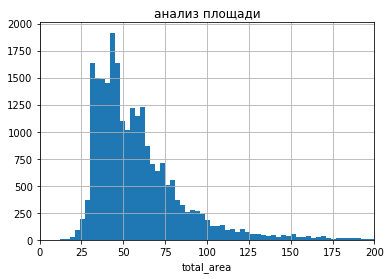

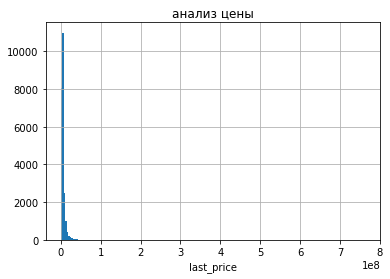

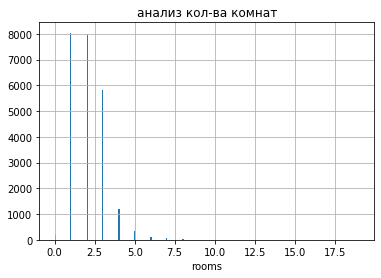

Text(0.5, 0, 'ceiling_height')

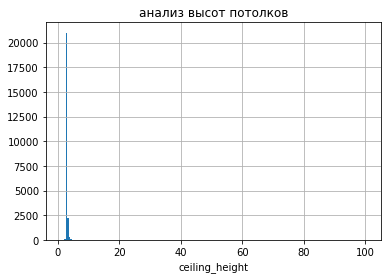

In [6]:
#изучаем следующие параметры: площадь, цена, число комнат, высота потолков
    
import matplotlib.pyplot as plt

data['total_area'].hist(bins=200, range = (0, 600))
plt.xlim([0, 200])
plt.title("анализ площади")
plt.xlabel("total_area")
plt.show()
data['last_price'].hist(bins=200)
plt.title("анализ цены")
plt.xlabel("last_price")
plt.show()
data['rooms'].hist(bins=200)
plt.title("анализ кол-ва комнат")
plt.xlabel("rooms")
plt.show()
data['ceiling_height'].hist(bins=200)
plt.title("анализ высот потолков")
plt.xlabel("ceiling_height")

count    20518
mean       180
std        219
min          1
25%         45
50%         95
75%        232
max       1580
Name: days_exposition, dtype: int64

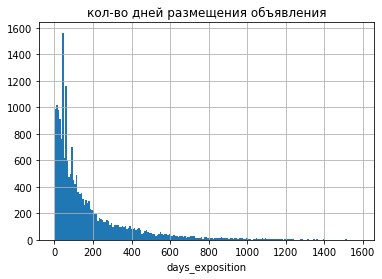

In [7]:
#Изучаем время продажи квартиры
data['days_exposition'].hist(bins=200)
plt.title("кол-во дней размещения объявления")
plt.xlabel("days_exposition")
display(data.days_exposition.describe().astype('int'))

Обычно продажа занимает 219 дней
Можно считать, что продажа прошла очень быстро,
если на это ушло меньше 45 дней
Если продажа занимает свыше 232 дней, означает что продажа долгая


    находим границы нормальных значений для общей площади по диаграмме размаха(см. ниже)
    нижняя граница - 12
    верхняя - около 110
    делаем соответствующий срез, удаляя выбросы

count    23699
mean        60
std         35
min         12
25%         40
50%         52
75%         69
max        900
Name: total_area, dtype: int64

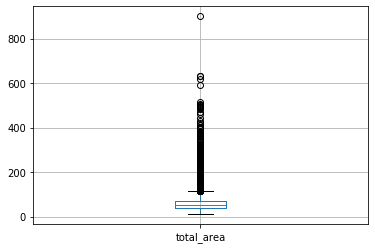

In [8]:
data.boxplot(column='total_area')
display(data.total_area.describe().astype('int'))
total_area_free = data.query('12 < total_area < 110')


    
    находим границы нормальных значений для стоимости по диаграмме размаха(см. ниже)
    нижняя граница - находится в нулевом значении
    верхняя - около 1200000
    делаем соответствующий срез, удаляя выбросы

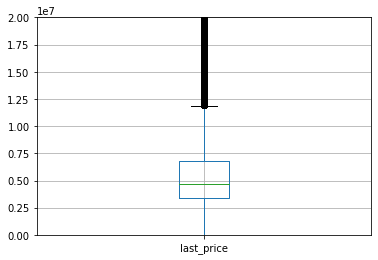

In [9]:
import matplotlib.pyplot as plt
data.boxplot(column='last_price')
plt.ylim(0, 2e7)
last_price_free = data.query('last_price < 1200000')

   
    находим границы нормальных значений для кол-ва комнат по диаграмме размаха(см. ниже)
    нижняя граница - 0 (наверное это студии + свободная планировка)
    верхняя - около 6 комнат
    делаем соответствующий срез, удаляя выбросы

count    23699
mean         2
std          1
min          0
25%          1
50%          2
75%          3
max         19
Name: rooms, dtype: int64

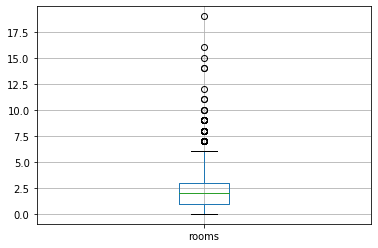

In [10]:
import matplotlib.pyplot as plt
data.boxplot(column='rooms')
display(data.rooms.describe().astype('int'))
rooms_free = data.query('0 < rooms < 6')


    находим границы нормальных значений для высот потолка по диаграмме размаха(см. ниже)
    нижняя граница равна верхней, так как строительство типовое = 2.77

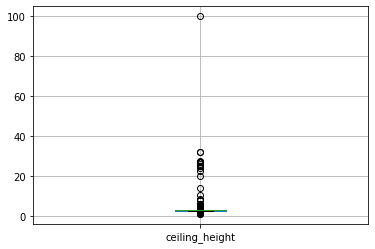

In [11]:
import matplotlib.pyplot as plt
data.boxplot(column='ceiling_height')
#display(data['ceiling_height'].mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 31 columns):
total_images               23699 non-null int64
last_price                 23699 non-null float64
total_area                 23699 non-null float64
first_day_exposition       23699 non-null datetime64[ns]
rooms                      23699 non-null int64
ceiling_height             23699 non-null float64
floors_total               23699 non-null int64
living_area                23699 non-null float64
floor                      23699 non-null int64
is_apartment               23699 non-null bool
studio                     23699 non-null bool
open_plan                  23699 non-null bool
kitchen_area               23699 non-null float64
balcony                    23699 non-null int64
locality_name              23650 non-null object
airports_nearest_km        18157 non-null float64
city_centers_nearest_km    18180 non-null float64
parks_around_3km           23699 non-null int64
parks_

None

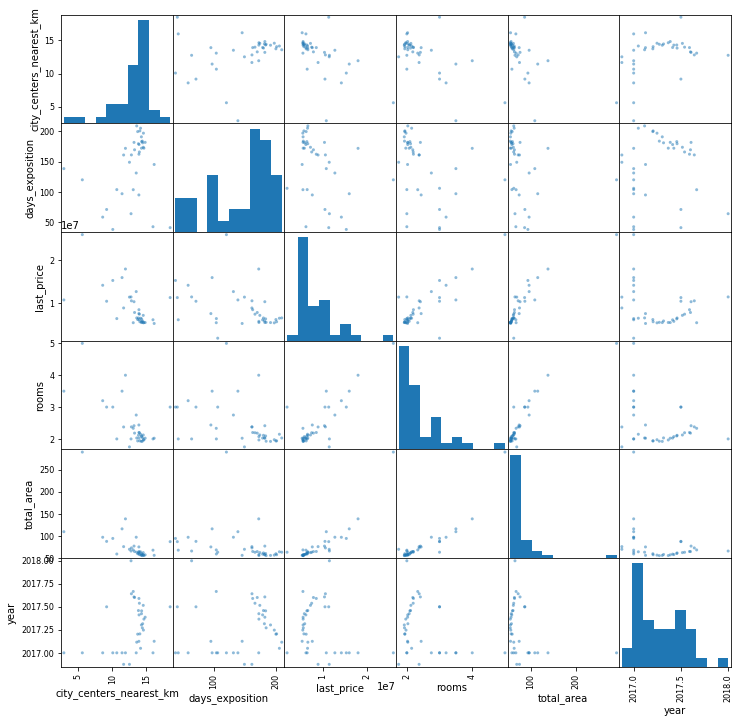

In [12]:
#изучаем какие факторы больше всего влияют на стоимость
price_2 = data.pivot_table(index='total_images', values=['last_price', 'total_area', 'rooms', 'city_centers_nearest_km', 'days_exposition', 'month', 'year'])
pd.plotting.scatter_matrix(price_2, figsize=(12, 12))
display(data.info())

In [13]:
display(data.corr())
display((data['floor_flat'] == 'первый этаж').corr(data['last_price']))
display((data['floor_flat'] == 'последний этаж').corr(data['last_price']))
display((data['floor_flat'] == 'другой этаж').corr(data['last_price']))

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,parks_nearest_km,ponds_around_3km,ponds_nearest_km,days_exposition,m2_price,nuber_day,living_total_area,kitchen_total_area,nuber_month,year
total_images,1.000000,0.104473,0.115352,0.099288,-0.001541,0.014896,0.104863,0.031340,0.010532,-0.029303,...,-0.008347,0.011323,-0.003034,-0.026657,0.132780,-1.043285e-02,-0.005548,-5.446260e-02,0.005043,0.140411
last_price,0.104473,1.000000,0.653675,0.363343,0.062504,-0.007094,0.556410,0.026576,0.026958,-0.025362,...,-0.016414,0.208621,-0.084809,0.081146,0.736499,1.550145e-03,-0.035560,-1.188332e-01,0.002779,-0.043089
total_area,0.115352,0.653675,1.000000,0.758344,0.077497,-0.075629,0.910988,-0.024754,0.029633,-0.072653,...,-0.021497,0.200294,-0.097969,0.149675,0.301960,-4.694724e-03,0.077546,-3.663253e-01,0.004920,-0.079912
rooms,0.099288,0.363343,0.758344,1.000000,0.043415,-0.225959,0.854108,-0.150862,0.000399,-0.147286,...,-0.054549,0.121276,-0.057689,0.126961,0.055420,-4.134116e-03,0.458260,-6.036558e-01,-0.004469,-0.055418
ceiling_height,-0.001541,0.062504,0.077497,0.043415,1.000000,-0.021067,0.074617,-0.008726,0.145297,0.001204,...,-0.016399,0.057929,-0.047209,0.014972,0.096725,-7.060140e-03,0.002484,1.185567e-02,-0.001097,-0.010501
floors_total,0.014896,-0.007094,-0.075629,-0.225959,-0.021067,1.000000,-0.169344,0.667070,-0.025958,0.066999,...,0.095235,-0.049188,0.039854,-0.051895,0.146509,1.191846e-02,-0.343589,3.300082e-01,0.016538,0.009269
living_area,0.104863,0.556410,0.910988,0.854108,0.074617,-0.169344,1.000000,-0.098802,0.028785,-0.056385,...,-0.053952,0.178381,-0.082017,0.139572,0.211583,-5.551268e-03,0.400219,-4.860954e-01,-0.001012,-0.072442
floor,0.031340,0.026576,-0.024754,-0.150862,-0.008726,0.667070,-0.098802,1.000000,-0.013294,0.036940,...,0.073045,-0.029710,0.024850,-0.039463,0.129068,1.234677e-02,-0.253718,2.294965e-01,0.019387,0.004915
is_apartment,0.010532,0.026958,0.029633,0.000399,0.145297,-0.025958,0.028785,-0.013294,1.000000,-0.003657,...,-0.033410,0.024400,0.003357,0.015262,0.044725,-9.491715e-03,0.002732,1.360090e-02,0.002369,0.009413
studio,-0.029303,-0.025362,-0.072653,-0.147286,0.001204,0.066999,-0.056385,0.036940,-0.003657,1.000000,...,0.009134,-0.009690,0.002606,-0.022476,0.015636,-8.434712e-04,0.085131,1.780313e-01,0.000976,0.011961


-0.059809733043746885

0.030466939391086453

0.02054329107735828

изучение зависимостей применив метод corr():  
    1.зависимость цены от площади - корреляция в 0.65 говорит о несильной зависимости  
    2.зависимость цены от числа комнат - корреляция в 0.36 говорит о слабой зависимости  
    3.зависимость цены от удаленности от центра - корреляция в -0.2 говорит о слабой зависимости  
    4.зависимость цены от первого этажа - корреляция в -0.059 говорит о несильной зависимости  
    5.зависимость цены от последнего этажа - корреляция в -0.059 говорит о несильной зависимости  
    6.зависимость цены от этажей не являющимися ни первым ни последним - корреляция в 0.02 говорит о слабой зависимости  

In [14]:
#Выбираем 10 населенных пунктов
display(data.groupby('locality_name')['locality_name'].count().sort_values(ascending = False).head(10))
display()
spb = data.query('locality_name == "Санкт-Петербург"')
spb_mean = spb['m2_price'].mean()
display('Сакт-Петербург: {:.2f}'.format(spb_mean))

murino = data.query('locality_name == "посёлок Мурино"')
murino_mean = murino['m2_price'].mean()
display('посёлок Мурино: {:.2f}'.format(murino_mean))

shushary = data.query('locality_name == "посёлок Шушары"')
shushary_mean = shushary['m2_price'].mean()
display('посёлок Шушары: {:.2f}'.format(shushary_mean))

vsevolzsk = data.query('locality_name == "Всеволожск"')
vsevolzsk_mean = vsevolzsk['m2_price'].mean()
display('Всеволожск: {:.2f}'.format(vsevolzsk_mean))

pushkin = data.query('locality_name == "Пушкин"')
pushkin_mean = pushkin['m2_price'].mean()
display('Пушкин: {:.2f}'.format(pushkin_mean))

kolpino = data.query('locality_name == "Колпино"')
kolpino_mean = kolpino['m2_price'].mean()
display('Колпино: {:.2f}'.format(kolpino_mean))

pargolovo = data.query('locality_name == "посёлок Парголово"')
pargolovo_mean = pargolovo['m2_price'].mean()
display('посёлок Парголово: {:.2f}'.format(pargolovo_mean))

gatchina = data.query('locality_name == "Гатчина"')
gatchina_mean = gatchina['m2_price'].mean()
display('Гатчина: {:.2f}'.format(gatchina_mean))

kudrovo = data.query('locality_name == "деревня Кудрово"')
kudrovo_mean = kudrovo['m2_price'].mean()
display('деревня Кудрово: {:.2f}'.format(kudrovo_mean))

vyborg = data.query('locality_name == "Выборг"')
vyborg_mean = vyborg['m2_price'].mean()
display('Выборг: {:.2f}'.format(vyborg_mean))

locality_name
Санкт-Петербург      15721
посёлок Мурино         522
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64

'Сакт-Петербург: 114849.01'

'посёлок Мурино: 85752.19'

'посёлок Шушары: 78677.36'

'Всеволожск: 68654.47'

'Пушкин: 103125.82'

'Колпино: 75424.58'

'посёлок Парголово: 90175.91'

'Гатчина: 68746.15'

'деревня Кудрово: 92473.55'

'Выборг: 58141.91'

In [15]:
df = pd.DataFrame(
    {
        'city': [
            'Санкт-Петербург',
            'посёлок Мурино',
            'посёлок Шушары',
            'Всеволожск',
            'Пушкин',
            'Колпино',
            'посёлок Парголово',
            'Гатчина',
            'деревня Кудрово',
            'Выборг'
        ],
        'price': [15721, 522, 440, 398, 369, 338, 327, 307, 299, 237],
        
    }
)

display(df)

,city,price
0,Санкт-Петербург,15721
1,посёлок Мурино,522
2,посёлок Шушары,440
3,Всеволожск,398
4,Пушкин,369
5,Колпино,338
6,посёлок Парголово,327
7,Гатчина,307
8,деревня Кудрово,299
9,Выборг,237


<BarContainer object of 10 artists>

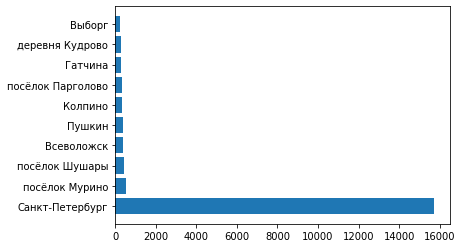

In [16]:
plt.barh(df['city'], width=df['price'])

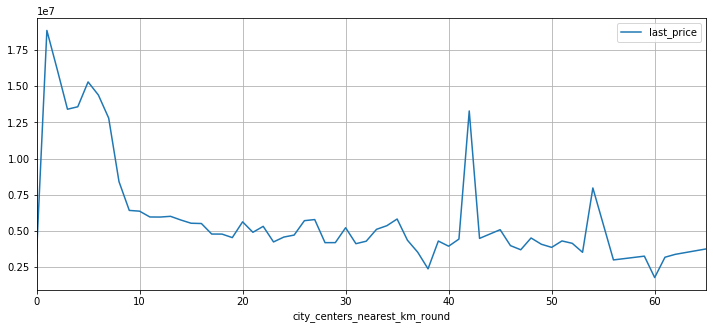

In [17]:
#Изучаем предложения квартир
#data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype('int')
data['city_centers_nearest_km_round'] = data['city_centers_nearest_km'].fillna(0)
data['city_centers_nearest_km_round'] = data['city_centers_nearest_km_round'].astype('int')
data.pivot_table(index='city_centers_nearest_km_round', values='last_price').plot(grid=True, figsize=(12, 5))


In [18]:
#выделяем сегмент квартир в центре
#print(data.query('city_centers_nearest_km_round < 10'))
resolt = data.query('city_centers_nearest_km_round < 10')
display(resolt.total_area.describe().astype('int'))
display(resolt.last_price.describe().astype('int'))
display(resolt.ceiling_height.describe().astype('int'))

count    10616
mean        66
std         44
min         12
25%         41
50%         55
75%         76
max        900
Name: total_area, dtype: int64

count        10616
mean       7755263
std       15789250
min          12190
25%        2700000
50%        4400000
75%        8100000
max      763000000
Name: last_price, dtype: int64

count    10616
mean         2
std          1
min          1
25%          2
50%          2
75%          2
max        100
Name: ceiling_height, dtype: int64

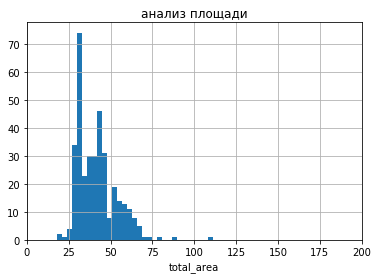

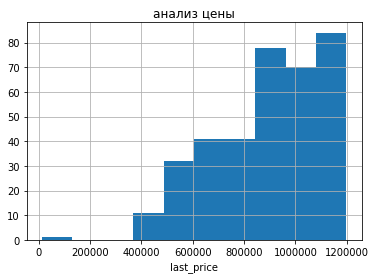

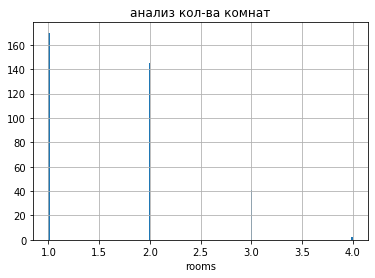

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,ponds_around_3km,ponds_nearest_km,days_exposition,m2_price,nuber_day,living_total_area,kitchen_total_area,nuber_month,year,city_centers_nearest_km_round
total_images,1.000000,0.071574,0.080818,0.043674,0.029468,-0.040603,0.036497,-0.062250,NaN,NaN,...,NaN,NaN,-0.059813,-0.034431,-0.008851,-0.086065,-0.085969,0.008766,0.249056,-0.015305
last_price,0.071574,1.000000,-0.021188,0.063680,-0.167302,-0.047086,0.053458,-0.111881,NaN,NaN,...,NaN,NaN,0.080375,0.659708,-0.055236,0.097418,-0.119522,0.013080,0.031554,-0.226514
total_area,0.080818,-0.021188,1.000000,0.827249,0.112714,0.192289,0.833056,0.170043,NaN,NaN,...,NaN,NaN,-0.038310,-0.686705,0.035583,0.158379,-0.504362,0.091049,0.016091,0.307780
rooms,0.043674,0.063680,0.827249,1.000000,0.109413,-0.063084,0.904237,-0.045477,NaN,NaN,...,NaN,NaN,-0.036040,-0.564576,0.074646,0.505742,-0.595049,0.081500,0.000024,0.026404
ceiling_height,0.029468,-0.167302,0.112714,0.109413,1.000000,-0.171133,0.111124,-0.059122,NaN,NaN,...,NaN,NaN,-0.067460,-0.202465,0.037851,0.048272,0.026522,0.008285,-0.114114,0.018313
floors_total,-0.040603,-0.047086,0.192289,-0.063084,-0.171133,1.000000,-0.030975,0.704681,NaN,NaN,...,NaN,NaN,-0.054058,-0.040036,-0.009987,-0.220788,0.044030,-0.018258,0.049974,0.580620
living_area,0.036497,0.053458,0.833056,0.904237,0.111124,-0.030975,1.000000,-0.051775,NaN,NaN,...,NaN,NaN,-0.080435,-0.574036,0.065805,0.644303,-0.534166,0.099570,-0.003446,0.038367
floor,-0.062250,-0.111881,0.170043,-0.045477,-0.059122,0.704681,-0.051775,1.000000,NaN,NaN,...,NaN,NaN,0.002923,-0.075624,-0.038610,-0.204737,0.048568,-0.025177,-0.038274,0.614144
is_apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


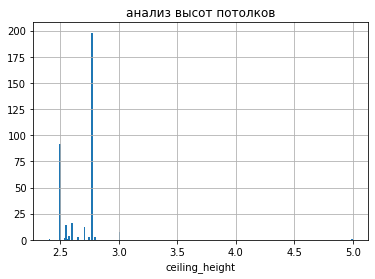

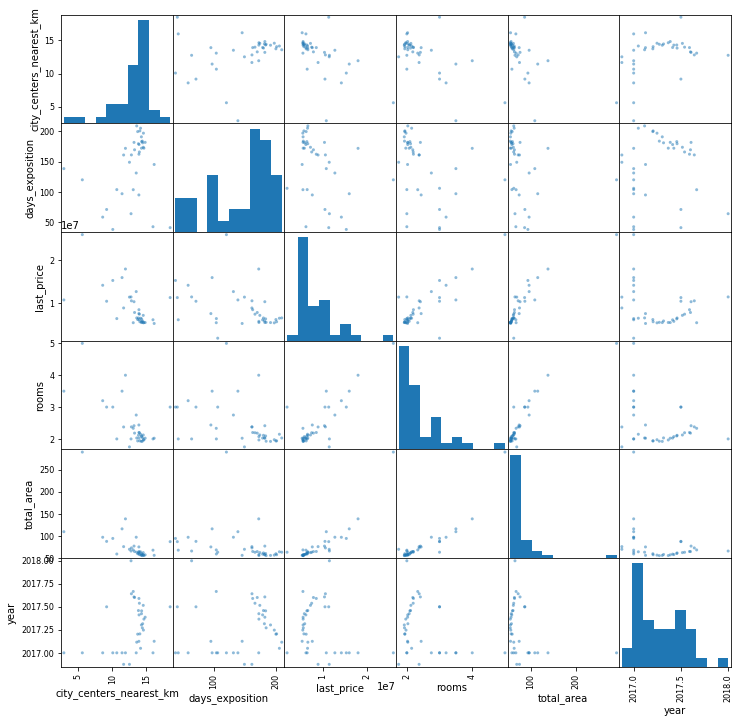

In [19]:
final = data.query('city_centers_nearest_km_round < 10 and (12 < total_area < 110) and last_price < 1200000 and (0 < rooms < 6)')
#display(final.head())

final['total_area'].hist(bins=200, range = (0, 600))
plt.xlim([0, 200])
plt.title("анализ площади")
plt.xlabel("total_area")
plt.show()

final['last_price'].hist()
plt.title("анализ цены")
plt.xlabel("last_price")
plt.show()

final['rooms'].hist(bins=200)
plt.title("анализ кол-ва комнат")
plt.xlabel("rooms")
plt.show()

final['ceiling_height'].hist(bins=200)
plt.title("анализ высот потолков")
plt.xlabel("ceiling_height")

total = final.pivot_table(index='total_images', values=['last_price', 'total_area', 'rooms', 'city_centers_nearest_km', 'days_exposition', 'month', 'year'])
pd.plotting.scatter_matrix(price_2, figsize=(12, 12))

display(final.corr())

## Общий вывод

Обычно продажа занимает 219 дней
Можно считать, что продажа прошла очень быстро, если на это ушло меньше 45 дней
Если продажа занимает свыше 232 дней, означает что продажа долгая

Стоимость зависит от площади: чем больше площадь, тем больше стоимость
Стоимость зависит от количества комнат: чем больше комнат, тем выше стоимость
Стоимость зависит от удаленности: чем дальше от центра, тем ниже стоимость

Самая высокая цена в Санкт_Петербурге
Самая низкая в Всеволожске

График показывает, что чем дальше от центра, тем цена меньше
Центр - до 10км

Квартиры в центральной части города более актуальные с диапазоном площади от 30 до 45 кв.м
 Стоимость таких квартир составляет порядка 900000-1200000
 Как правило, это одно- или двухкомнатные квартиры
 Зависимоть цены от площади (корреляция -0.03) несильная, скорее всего связана с достаточно узким диапазоном 
 площади и ее рыночной стоимости
 Зависимость цены от колва комнат (корреляция 0.06), имеет тенденцию: чем больше комнат, тем выше цена
 Учитывая типовое строительство, высота потолка 2.7 (корреляция -0.02), зависмость низкая
 Присутствует зависимость цены от кол-ва дней размещения объявления о продаже. 
    
    Картина в центральной части города отличается от общей:
        популярны квартиры с небольшой площадью и соответствующей небольшой стоимостью,
        чем дальше от центра, тем квартиры идут с большим количеством комнат